<a href="https://colab.research.google.com/github/MunJinSeo/MachineLearning/blob/main/%EA%B8%B0%EA%B3%84%ED%95%99%EC%8A%B5(AAI107)_Team13_%EC%A3%BC%EA%B0%80%EB%8F%99%ED%96%A5%EC%98%88%EC%B8%A1_20220609(%ED%9A%8C%EC%82%AC5).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 기계학습(AAI107)_Team13 (서문진, 서혜인, 이정은) 주가 동향 예측

## * 주가 이력 및 매매 정보 데이터와 금융 뉴스 감정 분석을 통한 "삼성전자" 주가 동향 예측



## 1) 배경 및 목적

- 주식가격 예측은 시계열에 유리한 LSTM/RNN등 모델을 사용하여 예측하는 경우가 많고 예측 정확도 50~60%를 넘기기 쉽지 않다고 한다.
또한 최근 강화학습을 사용하여 정확도를 높인 사례나 논문도 있으나 이 역시 만족할만한 수준은 아니고, 우리의 학습 범위를 벗어난다.

- 주식은 외부 변수가 너무 많고, 국가간의 영향과 현재 경제상황에도 영향을 받는 경우가 많다. 
또한 주식매매에 참여한 수많은 참가자들의 심리와 복잡한 상호작용을 모델링하여 주식 가격을 예측하는 것은 아직 불가능에 가깝다고 보여진다.

- 특정 주식의 과거 패턴을 학습했더라도 오늘자 주식은 그 패턴을 따르지 않는 경우가 많고, 과거 패턴보다는 어제,오늘 외부 환경에 따라 영향을 많이 받는다. 그리고, 특정 종목 패턴을 학습하더라도 타 종목에 적용하기도 어렵울것으로 보인다.

- **따라서 우리는 주식 가격에 영향을 주는 외부 요인이 어떤것이 있는지 찾아보고, 연관관계가 높은 데이터를 활용하여 내일의 주식가격 상승/보합/하강 을 판단하는 multiclass classification 과제로 접근 해보고자 한다.** 

- 향후 주식을 매매(buy,sell) 시기를 판단하도록 도와주는 자동 매매 예측기 기반을 마련해보고자 한다.

## 2) 주가에 영향 있어 보이는 외부 데이터 대상 후보

- 원달라 환율, 미국 국채금리, 미국 장단기 금리차
- 전날 미국 나스닥지수, 뉴욕지수 동향
- 종목 수익률 --제외(주가와 동일패턴)
- 전일 거래 동향 및 거래량
- 기관매매동향 , 외국인매매동향
- 공매도 동향
- 뉴스(금융/경제/주식) 감성 분석
- SNS 주식 감성분석 -- 제외(비효율적이며, 데이터 불리)
- 증시자금동향(고객,신용,혼합,채권) -- 제외(거래 동향으로 대체)

## 3) 삼성전자 주식 정보 수집

### 3-1) 삼성전자 주가 이력 및 KRX 주식 정보 수집

In [1]:
import pandas as pd
import numpy as np
import urllib.request # 데이터 파일 URL다운로드

from datetime import datetime
import time

In [2]:
# 삼성전자 주가 이력 및 KRX 주식 정보 수집
# "기계학습(AAI107)_Team13_주식_데이터_수집_20220608(회사2).ipynb" 으로 수집 후 github에 파일로 저장한 것을 로딩

urllib.request.urlretrieve("https://raw.githubusercontent.com/MunJinSeo/MachineLearning/main/samsung_stock_info_20180101-20220607.xlsx", filename="samsung_stock_info_20180101-20220607.xlsx")

('samsung_stock_info_20180101-20220607.xlsx',
 <http.client.HTTPMessage at 0x7f1ff66d1d90>)

In [3]:
samsung_stock_info = pd.read_excel("samsung_stock_info_20180101-20220607.xlsx", sheet_name=0, index_col=0)

In [4]:
samsung_stock_info

,Close,Change,Class,NextDay_Close,NextDay_Change,NextDay_Class,KOSPI_Close,KOSPI_Change,KOSPI_Class,USD_KRX_Close,...,종목공매도_거래량_Class,종목공매도_잔고수량,종목공매도_잔고수량_Change,종목공매도_잔고수량_Class,시장_공매도_기관,시장_공매도_기관_Change,시장_공매도_기관_Class,시장_공매도_외국인,시장_공매도_외국인_Change,시장_공매도_외국인_Class
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,51020,0.001177,1,51620.0,0.011760,1,2479.65,0.0049,1,1063.21,...,0,29723.0,NaN,0,1910431,NaN,0,6199347,NaN,0
2018-01-03,51620,0.011760,1,51080.0,-0.010461,-1,2486.35,0.0027,1,1064.80,...,1,31061.0,1338.0,1,1124108,-786323.0,-1,5861426,-337921.0,-1
2018-01-04,51080,-0.010461,-1,52120.0,0.020360,1,2466.46,-0.0080,-1,1062.28,...,-1,32137.0,1076.0,1,2250404,1126296.0,1,5610926,-250500.0,-1
2018-01-05,52120,0.020360,1,52020.0,-0.001919,-1,2497.52,0.0126,1,1062.09,...,1,34186.0,2049.0,1,2346393,95989.0,1,6356160,745234.0,1
2018-01-08,52020,-0.001919,-1,50400.0,-0.031142,-1,2513.28,0.0063,1,1068.86,...,-1,32530.0,-1656.0,-1,1826219,-520174.0,-1,5481423,-874737.0,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-30,67700,0.018045,1,67400.0,-0.004431,-1,2669.66,0.0120,1,1234.85,...,-1,7537085.0,-63891.0,-1,1221866,46041.0,1,6270816,660360.0,1
2022-05-31,67400,-0.004431,-1,66700.0,-0.010386,-1,2685.90,0.0061,1,1242.26,...,1,7699848.0,162763.0,1,1785899,564033.0,1,9174136,2903320.0,1
2022-06-02,66700,-0.010386,-1,66800.0,0.001499,1,2658.99,-0.0100,-1,1240.32,...,-1,6662284.0,-1037564.0,-1,1346907,-438992.0,-1,9272285,98149.0,1


### 3-2) 삼성전자 금융 뉴스 수집 및 감성 분석 결과

In [5]:
# 삼성전자 금융 뉴스 수집 및 감성 분석 결과
# "기계학습(AAI107)_Team13_뉴스크롤링_감성분석_20220608(회사2).ipynb" 으로 수집 후 github에 파일로 저장한 것을 로딩

urllib.request.urlretrieve("https://raw.githubusercontent.com/MunJinSeo/MachineLearning/main/samsung_news_emotion_20180101-20220607_title.xlsx", filename="samsung_news_emotion_20180101-20220607_title.xlsx")

('samsung_news_emotion_20180101-20220607_title.xlsx',
 <http.client.HTTPMessage at 0x7f1ff50c9690>)

In [6]:
#from xlrd.formula import colname
samsung_news_emotion_tmp = pd.read_excel("samsung_news_emotion_20180101-20220607_title.xlsx", sheet_name=0
                                         , usecols=['일자','제목','pred_label','negative','neutral','positive']
                                         )

In [7]:
# 열 이름 변경하기
samsung_news_emotion_tmp.rename(columns={'일자':'Date'}, inplace=True)

In [8]:
samsung_news_emotion_tmp

,Date,제목,pred_label,negative,neutral,positive
0,20181231,"화웨이, 글로벌 판매량 힘입어 프리미엄 스마트폰 첫 10%대 점유율",2,0.000058,0.000061,0.999881
1,20181231,증시 주저앉으며... 주식 100대 부자 자산 25조 증발,1,0.000058,0.999883,0.000058
2,20181231,"5G 보급 본격화, 헬스케어도 高성장 클라우드 엔터 자율車 바이오 '유망'",2,0.000035,0.000110,0.999855
3,20181231,여명-눈물 닦아주는 기해년을 기대하며,1,0.000161,0.999715,0.000124
4,20181231,2019 증시 키워드 GOLD PIG,1,0.000047,0.999892,0.000061
...,...,...,...,...,...,...
70332,20220101,"""반도체부터 리츠까지"" 증권사가 '이구동성' 추천한 주식은?",1,0.000063,0.999830,0.000106
70333,20220101,주식부호 톱 5위에 ‘이재용 홍라희 이부진 이서현’ 올라,1,0.003435,0.825722,0.170843
70334,20220101,연말 효과 무색 코스피 '1월 효과'로 다시 날까 [다음주 증시전망],1,0.000038,0.999921,0.000042
70335,20220101,"""올 한국증시, 미국보다 나을 수도"" 펀드매니저들 입 모았다 [다시 열자! 3000시대]",1,0.000036,0.999912,0.000053


### 3-3) 데이터 포멧 맞추기

In [9]:
# 일자 포멧을 통일
samsung_news_emotion = samsung_news_emotion_tmp.copy()
samsung_news_emotion["Date"] = [ datetime.strptime(str(ss), "%Y%m%d") for ss in samsung_news_emotion_tmp["Date"] ]

In [10]:
samsung_news_emotion

,Date,제목,pred_label,negative,neutral,positive
0,2018-12-31,"화웨이, 글로벌 판매량 힘입어 프리미엄 스마트폰 첫 10%대 점유율",2,0.000058,0.000061,0.999881
1,2018-12-31,증시 주저앉으며... 주식 100대 부자 자산 25조 증발,1,0.000058,0.999883,0.000058
2,2018-12-31,"5G 보급 본격화, 헬스케어도 高성장 클라우드 엔터 자율車 바이오 '유망'",2,0.000035,0.000110,0.999855
3,2018-12-31,여명-눈물 닦아주는 기해년을 기대하며,1,0.000161,0.999715,0.000124
4,2018-12-31,2019 증시 키워드 GOLD PIG,1,0.000047,0.999892,0.000061
...,...,...,...,...,...,...
70332,2022-01-01,"""반도체부터 리츠까지"" 증권사가 '이구동성' 추천한 주식은?",1,0.000063,0.999830,0.000106
70333,2022-01-01,주식부호 톱 5위에 ‘이재용 홍라희 이부진 이서현’ 올라,1,0.003435,0.825722,0.170843
70334,2022-01-01,연말 효과 무색 코스피 '1월 효과'로 다시 날까 [다음주 증시전망],1,0.000038,0.999921,0.000042
70335,2022-01-01,"""올 한국증시, 미국보다 나을 수도"" 펀드매니저들 입 모았다 [다시 열자! 3000시대]",1,0.000036,0.999912,0.000053


In [11]:
samsung_news_emotion_day_sum = samsung_news_emotion.groupby("Date").sum().copy()
samsung_news_emotion_day_sum

,pred_label,negative,neutral,positive
Date,,,,
2018-01-01,18,0.311959,17.523282,0.164759
2018-01-02,92,4.686755,58.150689,17.162556
2018-01-03,98,12.377176,42.188215,26.434609
2018-01-04,56,9.718460,39.047334,8.234207
2018-01-05,67,4.130927,33.281044,16.588030
...,...,...,...,...
2022-06-03,36,5.201451,23.680241,6.118307
2022-06-04,2,1.460670,1.519976,0.019353
2022-06-05,10,2.301941,5.873804,1.824255


In [12]:
samsung_news_emotion_day_mean = samsung_news_emotion.groupby("Date").mean().copy()
samsung_news_emotion_day_mean

,pred_label,negative,neutral,positive
Date,,,,
2018-01-01,1.000000,0.017331,0.973516,0.009153
2018-01-02,1.150000,0.058584,0.726884,0.214532
2018-01-03,1.209877,0.152805,0.520842,0.326353
2018-01-04,0.982456,0.170499,0.685041,0.144460
2018-01-05,1.240741,0.076499,0.616316,0.307186
...,...,...,...,...
2022-06-03,1.028571,0.148613,0.676578,0.174809
2022-06-04,0.666667,0.486890,0.506659,0.006451
2022-06-05,1.000000,0.230194,0.587380,0.182426


### 3-4) 데이터간 누락일자 비교

In [13]:
# 두 데이터간 누락일자 비교
df1 = pd.DataFrame({})
df2 = pd.DataFrame({})
df1["DT"] = samsung_stock_info.index.strftime('%Y-%m-%d').copy()
df2["DT"] = samsung_news_emotion_day_mean.index.strftime('%Y-%m-%d').copy()

df = pd.concat([df1,df2])
df = df.reset_index(drop=True) # 인덱스 초기화
 
df_grp = df.groupby("DT") # 전체 열 비교
df_di = df_grp.groups # 딕셔너리로 만들기 
 
idx = [x[0] for x in df_di.values() if len(x) == 1] # 인덱스 검토
df.loc[idx,:] # Same as df.reindex(idx)

,DT
1090,2018-01-01
1095,2018-01-06
1096,2018-01-07
1102,2018-01-13
1103,2018-01-14
...,...
2696,2022-05-29
2699,2022-06-01
2702,2022-06-04
2703,2022-06-05


### 3-5) 주식데이터와 뉴스 감성분석 데이터 합치기

In [14]:
# 주식데이터와 뉴스 감성분석 데이터 합치기
# 뉴스 휴일자 데이터 제외 함 (본 과제에서는)

samsung_stock_data = samsung_stock_info.copy()
#samsung_stock_data.join(samsung_news_emotion_day_mean, how='left')
#samsung_stock_data.keys()

#pred_label	negative	neutral	positive

# left index 에 맞춰서 들어감 , 우측 Date가 더 많지만 자동 삭제됨 (휴일 데이터)
samsung_stock_data["News_label_mean"] = samsung_news_emotion_day_mean["pred_label"]
samsung_stock_data["News_negative_mean"] = samsung_news_emotion_day_mean["negative"]
samsung_stock_data["News_neutral_mean"] = samsung_news_emotion_day_mean["neutral"]
samsung_stock_data["News_positive_mean"] = samsung_news_emotion_day_mean["positive"]

samsung_stock_data["News_label_sum"] = samsung_news_emotion_day_sum["pred_label"]
samsung_stock_data["News_negative_sum"] = samsung_news_emotion_day_sum["negative"]
samsung_stock_data["News_neutral_sum"] = samsung_news_emotion_day_sum["neutral"]
samsung_stock_data["News_positive_sum"] = samsung_news_emotion_day_sum["positive"]


In [15]:
samsung_stock_data

,Close,Change,Class,NextDay_Close,NextDay_Change,NextDay_Class,KOSPI_Close,KOSPI_Change,KOSPI_Class,USD_KRX_Close,...,시장_공매도_외국인_Change,시장_공매도_외국인_Class,News_label_mean,News_negative_mean,News_neutral_mean,News_positive_mean,News_label_sum,News_negative_sum,News_neutral_sum,News_positive_sum
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-02,51020,0.001177,1,51620.0,0.011760,1,2479.65,0.0049,1,1063.21,...,NaN,0,1.150000,0.058584,0.726884,0.214532,92,4.686755,58.150689,17.162556
2018-01-03,51620,0.011760,1,51080.0,-0.010461,-1,2486.35,0.0027,1,1064.80,...,-337921.0,-1,1.209877,0.152805,0.520842,0.326353,98,12.377176,42.188215,26.434609
2018-01-04,51080,-0.010461,-1,52120.0,0.020360,1,2466.46,-0.0080,-1,1062.28,...,-250500.0,-1,0.982456,0.170499,0.685041,0.144460,56,9.718460,39.047334,8.234207
2018-01-05,52120,0.020360,1,52020.0,-0.001919,-1,2497.52,0.0126,1,1062.09,...,745234.0,1,1.240741,0.076499,0.616316,0.307186,67,4.130927,33.281044,16.588030
2018-01-08,52020,-0.001919,-1,50400.0,-0.031142,-1,2513.28,0.0063,1,1068.86,...,-874737.0,-1,1.252874,0.158685,0.439008,0.402307,109,13.805579,38.193726,35.000694
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-30,67700,0.018045,1,67400.0,-0.004431,-1,2669.66,0.0120,1,1234.85,...,660360.0,1,0.950000,0.185800,0.685062,0.129138,38,7.432018,27.402462,5.165520
2022-05-31,67400,-0.004431,-1,66700.0,-0.010386,-1,2685.90,0.0061,1,1242.26,...,2903320.0,1,1.000000,0.211394,0.585326,0.203281,50,10.569679,29.266278,10.164043
2022-06-02,66700,-0.010386,-1,66800.0,0.001499,1,2658.99,-0.0100,-1,1240.32,...,98149.0,1,0.977778,0.083629,0.870001,0.046370,44,3.763302,39.150067,2.086632


### 3-6) 데이터 전처리

In [16]:
print("contain NaN values ?",np.any(np.isnan(samsung_stock_data) ) ) # NaN값 있는지 확인
samsung_stock_data.isnull().sum().sort_values(ascending=False) #컬럼별 NaN 값 수량계산

contain NaN values ? True


IXIC_Class           34
IXIC_Change          34
IXIC_Close           34
DJI_Class            34
DJI_Change           34
                     ..
종목거래실적_외국인_Class      0
시장거래실적_기관             0
시장거래실적_기관_Class       0
시장거래실적_외국인            0
News_positive_sum     0
Length: 77, dtype: int64

In [17]:
# NaN 값 있는 일자는 그냥 삭제 함 : 앞뒤 이웃값의 평균으로 해도 되겠으나, 수량도 적고 예측하기 어렵기때문에 삭제하는 것도 괜찮을것 같음
samsung_stock_data.dropna(inplace=True)
samsung_stock_data.isnull().sum().sort_values(ascending=False) #컬럼별 NaN 값 수량계산

Close                0
시장거래실적_외국인_Change    0
종목_외국인지분율_Class      0
종목_외국인지분율_Change     0
종목_외국인지분율            0
                    ..
T10Y2Y_Change        0
T10Y2Y               0
DGS1_Class           0
DGS1_Change          0
News_positive_sum    0
Length: 77, dtype: int64

### 3-7) 상관관계 분석

In [18]:
samsung_corr_matrix = samsung_stock_data.corr() # 상관관계 계산

In [ ]:
# 당일자 기준 다음일 변화량 상관관계
print(samsung_corr_matrix["NextDay_Change"].sort_values(ascending=False))

NextDay_Change    1.000000
NextDay_Class     0.758732
IXIC_Change       0.230895
DJI_Change        0.196209
IXIC_Class        0.180973
                    ...   
PBR              -0.061343
시장_공매도_기관        -0.066299
KOSPI_Change     -0.068061
USD_KRX_Class    -0.093559
USD_KRX_Change   -0.134027
Name: NextDay_Change, Length: 77, dtype: float64


In [ ]:
# 당일자 기준 다음일 분류(상승/보합/하강) 상관관계
print(samsung_corr_matrix["NextDay_Class"].sort_values(ascending=False))

NextDay_Class     1.000000
NextDay_Change    0.758732
IXIC_Change       0.190327
DJI_Change        0.166085
IXIC_Class        0.164535
                    ...   
PER              -0.061999
Close            -0.080027
PBR              -0.085611
KOSPI_Close      -0.086759
USD_KRX_Change   -0.097004
Name: NextDay_Class, Length: 77, dtype: float64


In [ ]:
# 당일자 기준 다음일 종가 상관관계
print(samsung_corr_matrix["NextDay_Close"].sort_values(ascending=False))

NextDay_Close    1.000000
Close            0.997756
IXIC_Close       0.929071
KOSPI_Close      0.905957
DJI_Close        0.885080
                   ...   
DGS20           -0.330220
시장_공매도_기관       -0.355810
DGS10           -0.436959
DGS5            -0.524207
DGS1            -0.737755
Name: NextDay_Close, Length: 77, dtype: float64


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47785 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44144 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47000 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 49892 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51201 missing from current font.
  font.set_

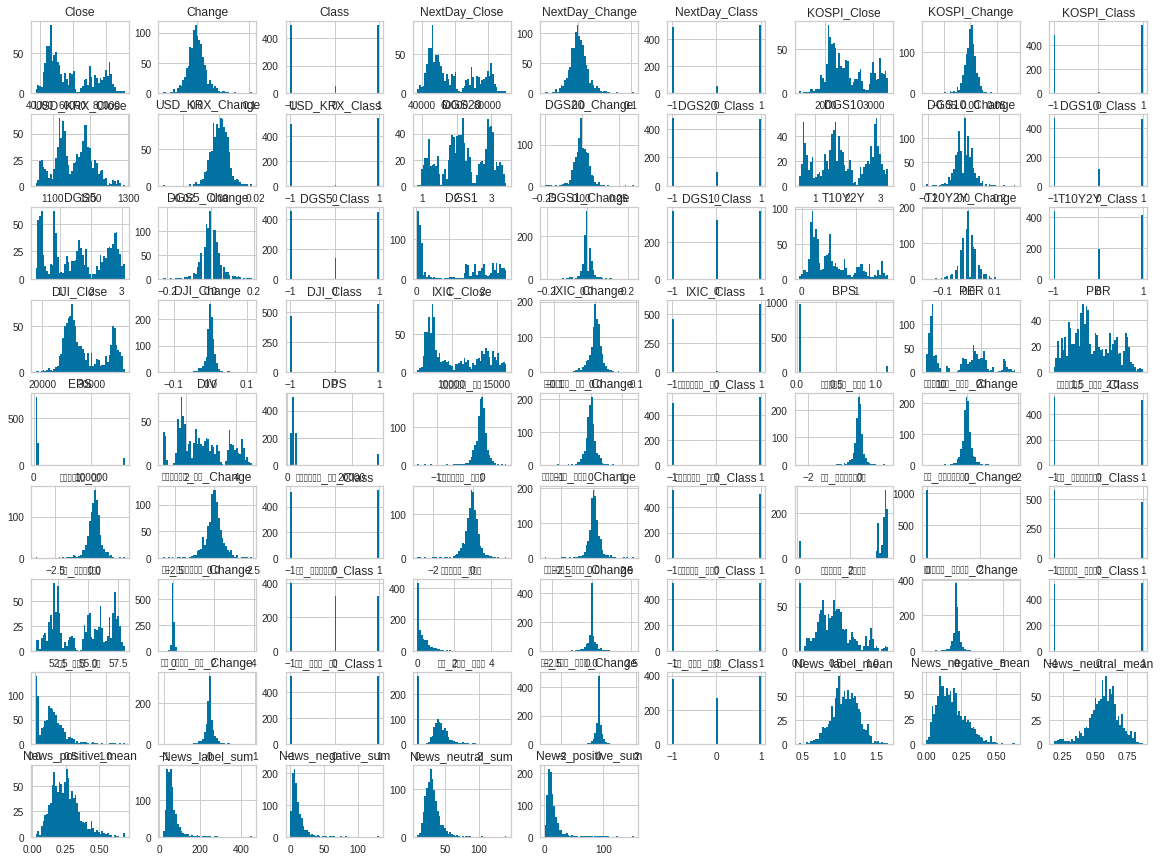

In [ ]:
samsung_stock_data.hist(bins=50, figsize=(20,15)) # 전체 feature 에 대해 histogram 표시 : bins값, figsize값은 교재 참고함
plt.show() #일괄로 표시

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


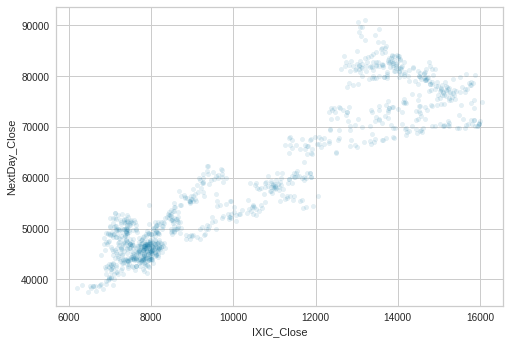

In [ ]:
samsung_stock_data.plot(kind="scatter", x="IXIC_Close", y="NextDay_Close", alpha=0.1) # 흩어뿌리기

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


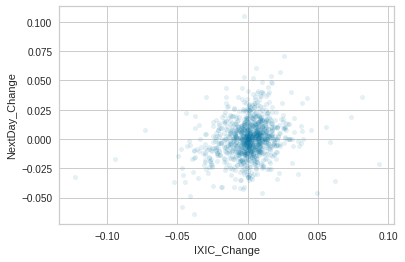

In [ ]:
samsung_stock_data.plot(kind="scatter", x="IXIC_Change", y="NextDay_Change", alpha=0.1) # 흩어뿌리기

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


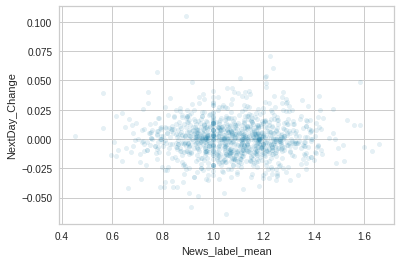

In [ ]:
#News_label_mean	News_negative_mean	News_neutral_mean	News_positive_mean

samsung_stock_data.plot(kind="scatter", x="News_label_mean", y="NextDay_Change", alpha=0.1) # 흩어뿌리기

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


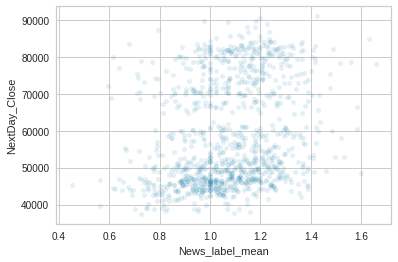

In [ ]:
samsung_stock_data.plot(kind="scatter", x="News_label_mean", y="NextDay_Close", alpha=0.1) # 흩어뿌리기

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


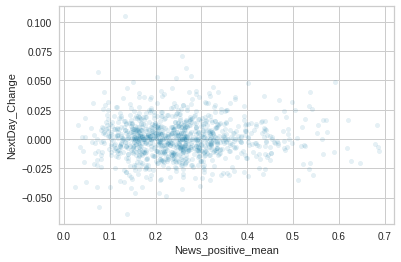

In [ ]:
samsung_stock_data.plot(kind="scatter", x="News_positive_mean", y="NextDay_Change", alpha=0.1) # 흩어뿌리기

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


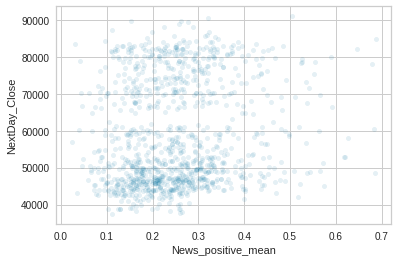

In [ ]:
samsung_stock_data.plot(kind="scatter", x="News_positive_mean", y="NextDay_Close", alpha=0.1) # 흩어뿌리기

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47785 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44277 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44144 missing from current font.
  font.set_

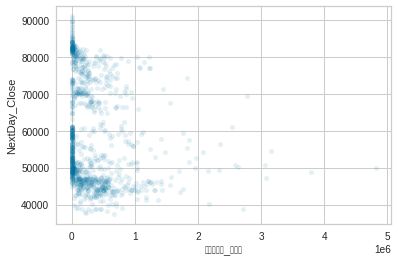

In [ ]:
samsung_stock_data.plot(kind="scatter", x="종목공매도_거래량", y="NextDay_Close", alpha=0.1) # 흩어뿌리기

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47785 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44277 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44144 missing from current font.
  font.set_

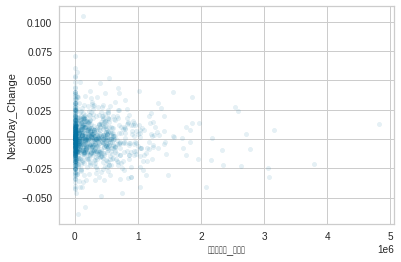

In [ ]:
samsung_stock_data.plot(kind="scatter", x="종목공매도_거래량", y="NextDay_Change", alpha=0.1) # 흩어뿌리기

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47785 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 50808 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44397 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51064 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51648 missing from current font.
  font.set_

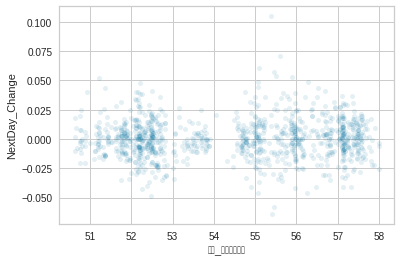

In [ ]:
samsung_stock_data.plot(kind="scatter", x="종목_외국인지분율", y="NextDay_Change", alpha=0.1) # 흩어뿌리기

## 4) 사용할 주식 정보(컬럼) 선정

In [19]:
samsung_stock_data.columns

Index(['Close', 'Change', 'Class', 'NextDay_Close', 'NextDay_Change',
       'NextDay_Class', 'KOSPI_Close', 'KOSPI_Change', 'KOSPI_Class',
       'USD_KRX_Close', 'USD_KRX_Change', 'USD_KRX_Class', 'DGS20',
       'DGS20_Change', 'DGS20_Class', 'DGS10', 'DGS10_Change', 'DGS10_Class',
       'DGS5', 'DGS5_Change', 'DGS5_Class', 'DGS1', 'DGS1_Change',
       'DGS1_Class', 'T10Y2Y', 'T10Y2Y_Change', 'T10Y2Y_Class', 'DJI_Close',
       'DJI_Change', 'DJI_Class', 'IXIC_Close', 'IXIC_Change', 'IXIC_Class',
       'BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS', '종목거래실적_기관',
       '종목거래실적_기관_Change', '종목거래실적_기관_Class', '종목거래실적_외국인',
       '종목거래실적_외국인_Change', '종목거래실적_외국인_Class', '시장거래실적_기관',
       '시장거래실적_기관_Change', '시장거래실적_기관_Class', '시장거래실적_외국인',
       '시장거래실적_외국인_Change', '시장거래실적_외국인_Class', '종목_외국인보유수량',
       '종목_외국인보유수량_Change', '종목_외국인보유수량_Class', '종목_외국인지분율',
       '종목_외국인지분율_Change', '종목_외국인지분율_Class', '종목공매도_거래량', '종목공매도_거래량_Change',
       '종목공매도_거래량_Class', '종목공매도_잔고수량', '종목공매도_잔

#### 컬럼 변수 정의(Case별)

In [20]:
# 예측에 사용할 컬럼 선정

# sales[sales['컬럼명'].str.contains('검색하고자 하는 문자열')]
#samsung_stock_data.columns[samsung_stock_data.keys().str.contains('Change')]
#Change_colums = samsung_stock_data.keys()[samsung_stock_data.keys().str.contains('Change')]
#Class_colums = samsung_stock_data.keys()[samsung_stock_data.keys().str.contains('Class')]
#News_colums = samsung_stock_data.keys()[samsung_stock_data.keys().str.contains('News')]

# RandomForest AUC= 0.5941072539238393 ~ 0.61...
needcol1 = ['NextDay_Change','NextDay_Class' # target label : NextDay_Class
       ,'Change','Class'
       ,'KOSPI_Change','KOSPI_Class'
       ,'USD_KRX_Change','USD_KRX_Class'
       ,'DGS20_Change','DGS20_Class'
       ,'DGS10_Change','DGS10_Class'
       ,'DGS5_Change','DGS5_Class'
       ,'DGS1_Change','DGS1_Class'
       ,'T10Y2Y_Change','T10Y2Y_Class'
       ,'DJI_Change', 'DJI_Class'
       ,'IXIC_Change', 'IXIC_Class'
       ,'BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS'
       ,'종목거래실적_기관_Change', '종목거래실적_기관_Class'
       ,'종목거래실적_외국인_Change', '종목거래실적_외국인_Class'
       ,'시장거래실적_기관_Change', '시장거래실적_기관_Class'
       ,'시장거래실적_외국인_Change', '시장거래실적_외국인_Class'
       ,'종목_외국인보유수량_Change', '종목_외국인보유수량_Class'
       ,'종목_외국인지분율_Change', '종목_외국인지분율_Class'
       ,'종목공매도_거래량_Change','종목공매도_거래량_Class'
       ,'종목공매도_잔고수량_Change','종목공매도_잔고수량_Class'
       ,'시장_공매도_기관_Change', '시장_공매도_기관_Class'
       ,'시장_공매도_외국인_Change', '시장_공매도_외국인_Class'
       ,'News_label_mean', 'News_negative_mean', 'News_neutral_mean','News_positive_mean'
       ,'News_label_sum', 'News_negative_sum','News_neutral_sum', 'News_positive_sum'
       ]

# RandomForest AUC= 0.5436931940390825
needcol2 = ['NextDay_Class' # target label : NextDay_Class
       ,'Change'
       ,'KOSPI_Change'
       ,'USD_KRX_Change'
       ,'DGS20_Change'
       ,'DGS10_Change'
       ,'DGS5_Change'
       ,'DGS1_Change'
       ,'T10Y2Y_Change'
       ,'DJI_Change'
       ,'IXIC_Change'
       #,'BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS'
       ,'종목거래실적_기관_Change'
       ,'종목거래실적_외국인_Change'
       ,'시장거래실적_기관_Change'
       ,'시장거래실적_외국인_Change'
       ,'종목_외국인보유수량_Change'
       ,'종목_외국인지분율_Change'
       ,'종목공매도_거래량_Change'
       ,'종목공매도_잔고수량_Change'
       ,'시장_공매도_기관_Change'
       ,'시장_공매도_외국인_Change'
       ,'News_label_mean', 'News_negative_mean', 'News_neutral_mean','News_positive_mean'
       #,'News_label_sum', 'News_negative_sum','News_neutral_sum', 'News_positive_sum'
       ]

# DecisionTree AUC= 0.5640080576074831
needcol3 = ['NextDay_Class' # target label : NextDay_Class
       ,'Class'
       ,'KOSPI_Class'
       ,'USD_KRX_Class'
       ,'DGS20_Class'
       ,'DGS10_Class'
       ,'DGS5_Class'
       ,'DGS1_Class'
       ,'T10Y2Y_Class'
       , 'DJI_Class'
       , 'IXIC_Class'
       #,'BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS'
       , '종목거래실적_기관_Class'
       , '종목거래실적_외국인_Class'
       , '시장거래실적_기관_Class'
       , '시장거래실적_외국인_Class'
       , '종목_외국인보유수량_Class'
       , '종목_외국인지분율_Class'
       ,'종목공매도_거래량_Class'
       ,'종목공매도_잔고수량_Class'
       , '시장_공매도_기관_Class'
       , '시장_공매도_외국인_Class'
       ,'News_label_mean', 'News_negative_mean', 'News_neutral_mean','News_positive_mean'
       #,'News_label_sum', 'News_negative_sum','News_neutral_sum', 'News_positive_sum'
       ]

# OneVsRestClassifier AUC= 0.5673691822640377
needcol4 = ['NextDay_Class' # target label : NextDay_Class
       ,'Class'
       ,'KOSPI_Class'
       ,'USD_KRX_Class'
       ,'DGS20_Class'
       ,'DGS10_Class'
       ,'DGS5_Class'
       ,'DGS1_Class'
       ,'T10Y2Y_Class'
       , 'DJI_Class'
       , 'IXIC_Class'
       #,'BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS'
       , '종목거래실적_기관_Class'
       , '종목거래실적_외국인_Class'
       , '시장거래실적_기관_Class'
       , '시장거래실적_외국인_Class'
       , '종목_외국인보유수량_Class'
       , '종목_외국인지분율_Class'
       ,'종목공매도_거래량_Class'
       ,'종목공매도_잔고수량_Class'
       , '시장_공매도_기관_Class'
       , '시장_공매도_외국인_Class'
       ,'News_label_mean', 'News_negative_mean', 'News_neutral_mean','News_positive_mean'
       ,'News_label_sum', 'News_negative_sum','News_neutral_sum', 'News_positive_sum'
       ]

# OneVsRestClassifier AUC= 0.5425715959763671
needcol5 = ['NextDay_Class' # target label : NextDay_Class
       ,'Class'
       ,'KOSPI_Class'
       ,'USD_KRX_Class'
       ,'DGS20_Class'
       ,'DGS10_Class'
       ,'DGS5_Class'
       ,'DGS1_Class'
       ,'T10Y2Y_Class'
       , 'DJI_Class'
       , 'IXIC_Class'
       ,'BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS'
       , '종목거래실적_기관_Class'
       , '종목거래실적_외국인_Class'
       , '시장거래실적_기관_Class'
       , '시장거래실적_외국인_Class'
       , '종목_외국인보유수량_Class'
       , '종목_외국인지분율_Class'
       ,'종목공매도_거래량_Class'
       ,'종목공매도_잔고수량_Class'
       , '시장_공매도_기관_Class'
       , '시장_공매도_외국인_Class'
       ,'News_label_mean', 'News_negative_mean', 'News_neutral_mean','News_positive_mean'
       #,'News_label_sum', 'News_negative_sum','News_neutral_sum', 'News_positive_sum'
       ]

# RandomForest AUC= 0.5597985508795095 #0.6123969399402761
needcol6 = ['NextDay_Class' # target label : NextDay_Class
       ,'Class'
       ,'KOSPI_Class'
       ,'USD_KRX_Class'
       ,'DGS20_Class'
       ,'DGS10_Class'
       ,'DGS5_Class'
       ,'DGS1_Class'
       ,'T10Y2Y_Class'
       , 'DJI_Class'
       , 'IXIC_Class'
       ,'BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS'
       , '종목거래실적_기관_Class'
       , '종목거래실적_외국인_Class'
       , '시장거래실적_기관_Class'
       , '시장거래실적_외국인_Class'
       , '종목_외국인보유수량_Class'
       , '종목_외국인지분율_Class'
       ,'종목공매도_거래량_Class'
       ,'종목공매도_잔고수량_Class'
       , '시장_공매도_기관_Class'
       , '시장_공매도_외국인_Class'
       ,'News_label_mean', 'News_negative_mean', 'News_neutral_mean','News_positive_mean'
       ,'News_label_sum', 'News_negative_sum','News_neutral_sum', 'News_positive_sum'
       ]

# RandomForest 0.5532609824609248
needcol7 = ['NextDay_Class' # target label : NextDay_Class
       #,'Class'
       #,'KOSPI_Class'
       #,'USD_KRX_Class'
       #,'DGS20_Class'
       #,'DGS10_Class'
       #,'DGS5_Class'
       #,'DGS1_Class'
       #,'T10Y2Y_Class'
       #, 'DJI_Class'
       #, 'IXIC_Class'
       ,'BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS'
       #, '종목거래실적_기관_Class'
       #, '종목거래실적_외국인_Class'
       #, '시장거래실적_기관_Class'
       #, '시장거래실적_외국인_Class'
       #, '종목_외국인보유수량_Class'
       #, '종목_외국인지분율_Class'
       #,'종목공매도_거래량_Class'
       #,'종목공매도_잔고수량_Class'
       #, '시장_공매도_기관_Class'
       #, '시장_공매도_외국인_Class'
       ,'News_label_mean', 'News_negative_mean', 'News_neutral_mean','News_positive_mean'
       ,'News_label_sum', 'News_negative_sum','News_neutral_sum', 'News_positive_sum'
       ]

# RandomForest AUC= 0.5985684305423581 ~ 0.61...
needcol8 = ['NextDay_Change','NextDay_Class' # target label : NextDay_Class
       ,'Change','Class'
       ,'KOSPI_Change','KOSPI_Class'
       ,'USD_KRX_Change','USD_KRX_Class'
       ,'DGS20_Change','DGS20_Class'
       ,'DGS10_Change','DGS10_Class'
       ,'DGS5_Change','DGS5_Class'
       ,'DGS1_Change','DGS1_Class'
       ,'T10Y2Y_Change','T10Y2Y_Class'
       ,'DJI_Change', 'DJI_Class'
       ,'IXIC_Change', 'IXIC_Class'
       #,'BPS', 'PER', 'PBR', 'EPS', 'DIV', 'DPS'
       ,'종목거래실적_기관_Change', '종목거래실적_기관_Class'
       ,'종목거래실적_외국인_Change', '종목거래실적_외국인_Class'
       ,'시장거래실적_기관_Change', '시장거래실적_기관_Class'
       ,'시장거래실적_외국인_Change', '시장거래실적_외국인_Class'
       ,'종목_외국인보유수량_Change', '종목_외국인보유수량_Class'
       ,'종목_외국인지분율_Change', '종목_외국인지분율_Class'
       ,'종목공매도_거래량_Change','종목공매도_거래량_Class'
       ,'종목공매도_잔고수량_Change','종목공매도_잔고수량_Class'
       ,'시장_공매도_기관_Change', '시장_공매도_기관_Class'
       ,'시장_공매도_외국인_Change', '시장_공매도_외국인_Class'
       ,'News_label_mean', 'News_negative_mean', 'News_neutral_mean','News_positive_mean'
       #,'News_label_sum', 'News_negative_sum','News_neutral_sum', 'News_positive_sum'
       ]



#### 컬럼정의 변수 셋팅

In [21]:
needcol = needcol8

samsung_stock_ex = pd.DataFrame({})
samsung_stock_ex[needcol] = samsung_stock_data[needcol].copy()

In [22]:
samsung_stock_ex

,NextDay_Change,NextDay_Class,Change,Class,KOSPI_Change,KOSPI_Class,USD_KRX_Change,USD_KRX_Class,DGS20_Change,DGS20_Class,...,종목공매도_잔고수량_Change,종목공매도_잔고수량_Class,시장_공매도_기관_Change,시장_공매도_기관_Class,시장_공매도_외국인_Change,시장_공매도_외국인_Class,News_label_mean,News_negative_mean,News_neutral_mean,News_positive_mean
Date,,,,,,,,,,,,,,,,,,,,,
2018-01-03,-0.010461,-1,0.011760,1,0.0027,1,0.0015,1,-0.02,-1.0,...,1338.0,1,-786323.0,-1,-337921.0,-1,1.209877,0.152805,0.520842,0.326353
2018-01-04,0.020360,1,-0.010461,-1,-0.0080,-1,-0.0024,-1,0.00,0.0,...,1076.0,1,1126296.0,1,-250500.0,-1,0.982456,0.170499,0.685041,0.144460
2018-01-05,-0.001919,-1,0.020360,1,0.0126,1,-0.0002,-1,0.02,1.0,...,2049.0,1,95989.0,1,745234.0,1,1.240741,0.076499,0.616316,0.307186
2018-01-08,-0.031142,-1,-0.001919,-1,0.0063,1,0.0064,1,0.01,1.0,...,-1656.0,-1,-520174.0,-1,-874737.0,-1,1.252874,0.158685,0.439008,0.402307
2018-01-09,-0.030952,-1,-0.031142,-1,-0.0012,-1,0.0029,1,0.07,1.0,...,-191.0,-1,341682.0,1,1227779.0,1,1.338710,0.212924,0.243930,0.543146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-05-25,-0.007530,-1,-0.001504,-1,0.0044,1,0.0043,1,-0.02,-1.0,...,158987.0,1,95257.0,1,249162.0,1,1.190476,0.049590,0.696818,0.253593
2022-05-26,0.009105,1,-0.007530,-1,-0.0018,-1,-0.0050,-1,0.04,1.0,...,-439298.0,-1,31167.0,1,-2020632.0,-1,1.025000,0.170015,0.634740,0.195245
2022-05-27,0.018045,1,0.009105,1,0.0098,1,-0.0064,-1,-0.02,-1.0,...,-76141.0,-1,-471708.0,-1,-1232684.0,-1,1.062500,0.133690,0.707843,0.158468


## 5) 모델별 적용 및 예측 하기

### 5-1) 기본환경 셋팅

In [23]:
import pandas as pd
import numpy as np
np.random.seed(20220513)

# 모델 비교하기 위해 각 모델library import
from sklearn.linear_model import SGDClassifier  # Stochastic Gradient Descent Classifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


# To plot pretty figures --강의 교재 참고하여 추가함
# 실행한 브라우저에서 바로 그림을 볼 수 있게 해줌
%matplotlib inline
import matplotlib as mpl #그래프를 그리기 위한 Library
import matplotlib.pyplot as plt #그래프를 그리기 위한 Library

from sklearn.model_selection import train_test_split # sklearn에서 제공하는 데이터 분리 Library
from sklearn.model_selection import StratifiedShuffleSplit  # sklearn에서 제공하는 데이터 분리 Library

from sklearn.preprocessing import MinMaxScaler #sklearn에서 제공하는 Feature Scaling Library

from sklearn.model_selection import cross_val_score # 교차검증(Cross-Validation)  library import
from sklearn.model_selection import cross_val_predict # 교차검증(Cross-Validation)  library import, Confusion Matrix 평가를 위함

#from sklearn.metrics import mean_squared_error #평가 -> RMSE : 루트 평균 제곱 오차, MSE : 평균 제곱 오차
from sklearn.metrics import confusion_matrix #평가
from sklearn.metrics import precision_score, recall_score, f1_score, make_scorer
from sklearn.metrics import precision_recall_curve, roc_curve, auc # roc곡선: 양성으로 잘못판단한 것에 의한 진짜 양성의 비율함수
from yellowbrick.classifier import ROCAUC #roc 곡선 및 AUC 쉽게 그리도록 지원
from sklearn.metrics import roc_auc_score, accuracy_score #정확도 
from sklearn.metrics import classification_report

from sklearn.model_selection import GridSearchCV # sklearn에서 제공하는 하이퍼파라미터 조합 찾기

import joblib # 내 모델을 외부 저장/로딩
from google.colab import files

### 5-2) 데이터분리(Train,Valid)

In [24]:
#  Train, Valid 데이터 분리 진행

train_data, valid_data = train_test_split(samsung_stock_ex, test_size=0.2, random_state=42) # test_size는 비율 또는 정수값, random_state값은 random seed 생성시 항상 동일한 shuffle index 허용
print( "train_data.shape=",train_data.shape )
print( "valid_data.shape=",valid_data.shape )  

X_train = train_data[[c for c in samsung_stock_ex.columns if c not in ['NextDay_Change','NextDay_Class']]].copy()
y_train = train_data['NextDay_Class'].copy()
print( "X_train.shape=",X_train.shape )
print( "y_train.shape=",y_train.shape )

X_valid = valid_data[[c for c in samsung_stock_ex.columns if c not in ['NextDay_Change','NextDay_Class']]].copy()
y_valid = valid_data['NextDay_Class'].copy()
print( "X_valid.shape=",X_valid.shape )
print( "y_valid.shape=",y_valid.shape )

train_data.shape= (840, 46)
valid_data.shape= (210, 46)
X_train.shape= (840, 44)
y_train.shape= (840,)
X_valid.shape= (210, 44)
y_valid.shape= (210,)


In [25]:
X_train

,Change,Class,KOSPI_Change,KOSPI_Class,USD_KRX_Change,USD_KRX_Class,DGS20_Change,DGS20_Class,DGS10_Change,DGS10_Class,...,종목공매도_잔고수량_Change,종목공매도_잔고수량_Class,시장_공매도_기관_Change,시장_공매도_기관_Class,시장_공매도_외국인_Change,시장_공매도_외국인_Class,News_label_mean,News_negative_mean,News_neutral_mean,News_positive_mean
Date,,,,,,,,,,,,,,,,,,,,,
2020-05-11,-0.008197,-1,-0.0054,-1,0.0027,1,0.04,1.0,0.04,1.0,...,300364.0,1,-60433.0,-1,0.0,0,1.272727,0.146300,0.462809,0.390892
2022-04-06,-0.010116,-1,-0.0088,-1,-0.0006,-1,0.07,1.0,0.07,1.0,...,281084.0,1,805369.0,1,1690749.0,1,0.823529,0.403492,0.384640,0.211868
2020-01-16,0.028814,1,0.0077,1,0.0016,1,0.02,1.0,0.02,1.0,...,111604.0,1,1616554.0,1,-86998.0,-1,1.127273,0.119967,0.642443,0.237590
2019-11-04,0.021484,1,0.0143,1,-0.0016,-1,0.07,1.0,0.06,1.0,...,107123.0,1,-990723.0,-1,-1529407.0,-1,1.408163,0.043271,0.515704,0.441026
2020-08-24,0.003578,1,0.0110,1,-0.0026,-1,0.01,1.0,0.01,1.0,...,132808.0,1,-30892.0,-1,0.0,0,1.000000,0.257749,0.482938,0.259314
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-03,0.030588,1,0.0128,1,-0.0075,-1,-0.05,-1.0,-0.07,-1.0,...,630715.0,1,819607.0,1,2363427.0,1,0.968254,0.173786,0.629020,0.197194
2019-12-23,-0.008929,-1,-0.0002,-1,0.0035,1,0.01,1.0,0.01,1.0,...,842799.0,1,890241.0,1,-95824.0,-1,1.232143,0.113587,0.554234,0.332179
2018-07-13,0.021978,1,0.0113,1,0.0049,1,-0.02,-1.0,-0.02,-1.0,...,-39833.0,-1,-3129575.0,-1,-778249.0,-1,0.739130,0.384156,0.507533,0.108311


### 5-3) MinMax scale

In [26]:
# MinMax scale features into 0~1 (e.g., use MinMaxScaler)
scaler1 = MinMaxScaler() # 객체 생성 : X_train 용
scaler1.fit(X_train) # 피팅 : 스케일링에 사용할 최소,최대 값 계산하여 저장
X_train_scaled = scaler1.transform(X_train) # 데이터 변환, 결과는 배열로 반환됨
X_train = np.round(X_train_scaled,4) # 결과값들을 소수점 4째자리까지 반올림 (불필요값 제거)

scaler2 = MinMaxScaler() # 객체 생성 : X_valid 용
scaler2.fit(X_valid) # 피팅 : 스케일링에 사용할 최소,최대 값 계산하여 저장
X_valid_scaled = scaler2.transform(X_valid) # 데이터 변환, 결과는 배열로 반환됨
X_valid = np.round(X_valid_scaled,4) # 결과값들을 소수점 4째자리까지 반올림 (불필요값 제거)

print("My Train data range :", np.min(X_train) , "~", np.max(X_train) )
print("My Valid data range :", np.min(X_valid) , "~", np.max(X_valid) )

My Train data range : 0.0 ~ 1.0
My Valid data range : 0.0 ~ 1.0


In [ ]:
#samsung_news_emotion["Date"] = [ datetime.strptime(str(ss), "%Y%m%d") for ss in samsung_news_emotion_tmp["Date"] ]
print(X_train.shape)
print(X_train)

(840, 44)
[[0.3303 0.     0.3443 ... 0.2293 0.4032 0.5538]
 [0.3189 0.     0.3199 ... 0.6338 0.2887 0.2842]
 [0.5498 1.     0.4383 ... 0.1878 0.6665 0.3229]
 ...
 [0.5093 1.     0.4641 ... 0.6034 0.4688 0.1282]
 [0.2566 0.     0.2704 ... 0.3825 0.5271 0.2798]
 [0.2656 0.     0.3558 ... 0.6599 0.3572 0.1888]]


### 5-4) AutoML 분석

In [ ]:
!pip3 install auto-sklearn #AutoML 설치
#!pip3 install --upgrade auto-sklearn #AutoML 설치

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# https://automl.github.io/auto-sklearn/master/examples/index.html
# https://automl.github.io/auto-sklearn/master/examples/20_basic/example_classification.html#sphx-glr-examples-20-basic-example-classification-py
# https://automl.github.io/auto-sklearn/master/api.html#classification

from pprint import pprint

import sklearn.datasets
import sklearn.metrics

import autosklearn.classification

In [ ]:
#X, y = sklearn.datasets.load_breast_cancer(return_X_y=True)
#X_train, X_test, y_train, y_test = \
#    sklearn.model_selection.train_test_split(X, y, random_state=1)

# AutoSklearnClassifier 파라미터 항목별 상세 내용은 아래 URL 참조
# https://automl.github.io/auto-sklearn/master/api.html

# automl = autosklearn.classification.AutoSklearnClassifier(
#    time_left_for_this_task=300, #(default=3600) Time limit in seconds for the search of appropriate models
#    per_run_time_limit=30, #(default=1/10 of time_left_for_this_task) Time limit for a single call to the machine learning model
#    ensemble_size=20, #(default=50) Number of models added to the ensemble built by Ensemble selection from libraries of models
#    #tmp_folder='autosklearn_classification_example_tmp' # folder to store configuration output and log files, if None automatically use /tmp/autosklearn_tmp_$pid_$random_number
#    #seed=42, # (default=1) Used to seed SMAC
#    #resampling_strategy='cv', # ‘cv’: crossvalidation, requires ‘folds’
#    #metric=autosklearn.metrics.roc_auc,
#)
automl = autosklearn.classification.AutoSklearnClassifier(
    time_left_for_this_task=500, # (default=3600) Time limit in seconds for the search of appropriate models
    per_run_time_limit=50, #(default=1/10 of time_left_for_this_task) Time limit for a single call to the machine learning model
    ensemble_size=30 # (default=50) Number of models added to the ensemble built by Ensemble selection from libraries of models
)

# Auto-sklearn ingests the pandas dataframe and detects column types
automl.fit(X_train, y_train)



AutoSklearnClassifier(ensemble_size=30, per_run_time_limit=50,
                      time_left_for_this_task=500)

In [ ]:
print(automl.leaderboard())
# 항목별 상세 내용은 아래 URL 참조
# https://automl.github.io/auto-sklearn/master/api.html

# "model_id" - The id given to a model by autosklearn.
# "rank" - The rank of the model based on it’s "cost".
# "ensemble_weight" - The weight given to the model in the ensemble.
# "type" - The type of classifier/regressor used.
# "cost" - The loss of the model on the validation set.
# "duration" - Length of time the model was optimized for.

          rank  ensemble_weight           type      cost  duration
model_id                                                          
13           1         0.400000  random_forest  0.399281  3.201290
46           2         0.133333  random_forest  0.420863  2.773036
50           3         0.033333            lda  0.420863  1.277322
38           4         0.033333  random_forest  0.424460  3.423643
49           5         0.066667  decision_tree  0.431655  1.008260
22           6         0.033333    extra_trees  0.442446  2.671013
41           7         0.066667  random_forest  0.453237  2.837915
44           8         0.033333  random_forest  0.456835  3.993245
35           9         0.033333  random_forest  0.482014  3.539846
18          10         0.066667  random_forest  0.489209  3.341008
31          11         0.100000  random_forest  0.525180  3.359035


In [ ]:
predictions = automl.predict(X_valid)
#predictions_proba=automl.predict_proba(X_test)
print("Accuracy score:", sklearn.metrics.accuracy_score(y_valid, predictions))
#predictions_proba

Accuracy score: 0.5047619047619047


In [ ]:
print(automl.sprint_statistics())

auto-sklearn results:
  Dataset name: 1730bd64-e7b6-11ec-821c-0242ac1c0002
  Metric: accuracy
  Best validation score: 0.600719
  Number of target algorithm runs: 53
  Number of successful target algorithm runs: 48
  Number of crashed target algorithm runs: 2
  Number of target algorithms that exceeded the time limit: 3
  Number of target algorithms that exceeded the memory limit: 0



In [ ]:
pprint(automl.show_models(), indent=4)

### 5-5) 모델별 분석

#### OneVsRestClassifier

In [27]:
# ① OneVsRestClassifier() 모델 
#나이브 베이즈(naive bayes) 분류기는 선형 모델과 매우 유사함, LogisticRegression이나 LinearSVC 같은 선형 분류기 보다 훈련 속도가 빠르지만, 일반화 성능이 조금 뒤쳐짐
#각 특성을 개별로 취급해 파라미터를 학습하고 그 특성에서 클래스별 통계를 단순하게 취합
#GaussianNB : 연속적인 어떤 데이터에도 적용가능
#BernoulliNB : 이진(binary) 데이터에 적용가능
#MultinomialNB : 카운트 데이터(ex 문장에 나타난 단어의 횟수)에 적용가능
from sklearn.naive_bayes import GaussianNB, BernoulliNB, MultinomialNB

ovr_clf = OneVsRestClassifier(GaussianNB()) # 모델 객체 생성
ovr_clf.fit(X_train, y_train) # 모델 피팅 : X_train, y_train

OneVsRestClassifier(estimator=GaussianNB())

OneVsRestClassifier(GaussianNB()) confusion_matrix
 [[  1   0  96]
 [  0   0  10]
 [  0   0 103]]
accuracy= 0.49523809523809526
Precision: 0.49760765550239233
Recall: 0.3367697594501718
F1 score: 0.22688819117390546
AUC: 0.5024425121238398
              precision    recall  f1-score   support

          -1       1.00      0.01      0.02        97
           0       0.00      0.00      0.00        10
           1       0.49      1.00      0.66       103

    accuracy                           0.50       210
   macro avg       0.50      0.34      0.23       210
weighted avg       0.70      0.50      0.33       210



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

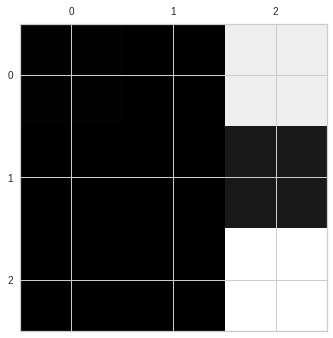

In [28]:
ovr_pred = ovr_clf.predict(X_valid) # X_valid 로 예측 label 생성
ovr_prob = ovr_clf.predict_proba(X_valid) #X_valid 로 예측 확률값 생성 
ovr_conf_mx =  confusion_matrix(y_valid, ovr_pred)
print( "OneVsRestClassifier(GaussianNB()) confusion_matrix\n", ovr_conf_mx )
print( "accuracy=", accuracy_score(y_valid, ovr_pred) )# 정확도
print('Precision:',precision_score(y_valid, ovr_pred, average = 'macro'))
print('Recall:',recall_score(y_valid, ovr_pred, average = 'macro'))
print('F1 score:',f1_score(y_valid, ovr_pred, average = 'macro'))
print('AUC:',roc_auc_score(y_valid, ovr_prob, multi_class = 'ovr'))
print(classification_report(y_valid, ovr_pred)) # 각 scores를 보기좋게 table 방식 표시

plt.matshow(ovr_conf_mx, cmap=plt.cm.gray) # matplot의 matshow()함수를 이용해서 시각적으로 확인
plt.show()

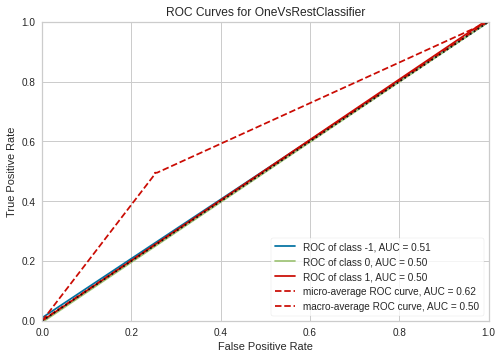

AUC= 0.5024425121238398


In [29]:
# ROC 커브 그리기
plt_roc_curve = ROCAUC(ovr_clf) #

# Fitting to the training data first then scoring with the test data                                    
plt_roc_curve.fit(X_train, y_train)
plt_roc_curve.score(X_valid, y_valid)
plt_roc_curve.show()

print("AUC=", plt_roc_curve.score_)

#### DecisionTreeClassifier

In [30]:
# ② DecisionTreeClassifier 모델
tree_clf = DecisionTreeClassifier() # 객체 생성
tree_clf.fit(X_train, y_train) # 모델 피팅 :X_train, y_train

DecisionTreeClassifier()

DecisionTreeClassifier confusion_matrix
 [[24  9 64]
 [ 3  1  6]
 [16  8 79]]
accuracy= 0.49523809523809526
Precision: 0.38129881090705187
Recall: 0.371470990558169
F1 score: 0.34708994708994706
AUC: 0.5345109618795864
              precision    recall  f1-score   support

          -1       0.56      0.25      0.34        97
           0       0.06      0.10      0.07        10
           1       0.53      0.77      0.63       103

    accuracy                           0.50       210
   macro avg       0.38      0.37      0.35       210
weighted avg       0.52      0.50      0.47       210



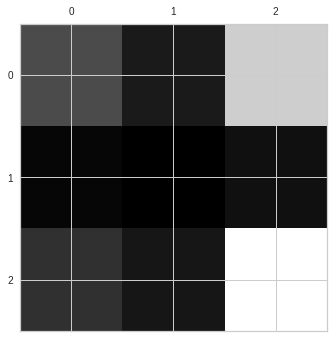

In [31]:
tree_pred = tree_clf.predict(X_valid) # X_valid로 예측 label 생성
tree_prob = tree_clf.predict_proba(X_valid) # X_valid 로 예측 확률값 생성
tree_conf_mx =  confusion_matrix(y_valid, tree_pred)
print( "DecisionTreeClassifier confusion_matrix\n", tree_conf_mx )
print( "accuracy=", accuracy_score(y_valid, tree_pred) )# 정확도
print('Precision:',precision_score(y_valid, tree_pred, average = 'macro'))
print('Recall:',recall_score(y_valid, tree_pred, average = 'macro'))
print('F1 score:',f1_score(y_valid, tree_pred, average = 'macro'))
print('AUC:',roc_auc_score(y_valid, tree_prob, multi_class = 'ovr'))
print(classification_report(y_valid, tree_pred)) # 각 scores를 보기좋게 table 방식 표시

plt.matshow(tree_conf_mx, cmap=plt.cm.gray) # matplot의 matshow()함수를 이용해서 시각적으로 확인
plt.show()

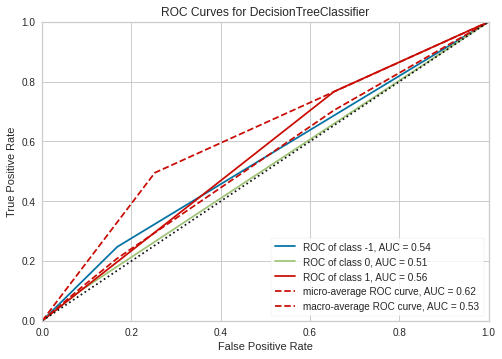

AUC= 0.5345109618795862


In [32]:
# ROC 커브 그리기
plt_roc_curve = ROCAUC(tree_clf) #

# Fitting to the training data first then scoring with the test data                                    
plt_roc_curve.fit(X_train, y_train)
plt_roc_curve.score(X_valid, y_valid)
plt_roc_curve.show()

print("AUC=", plt_roc_curve.score_)

#### RandomForestClassifier

In [55]:
# ③ RandomForestClassifier 모델
#forest_clf = RandomForestClassifier(max_depth = 3, random_state = 99) # 객체 생성
forest_clf = RandomForestClassifier(random_state = 99) # 객체 생성 #{'max_features': 5, 'n_estimators': 100}
#forest_clf = RandomForestClassifier(max_features = 5, n_estimators=100)
forest_clf.fit(X_train, y_train) # 모델 피팅 : X_train, y_train

RandomForestClassifier(random_state=99)

RandomForestClassifier confusion_matrix
 [[85  0 12]
 [ 9  0  1]
 [79  0 24]]
accuracy= 0.5190476190476191
Precision: 0.37999270947247826
Recall: 0.3697661228438928
F1 score: 0.3241622574955908
AUC: 0.5985003567666556
              precision    recall  f1-score   support

          -1       0.49      0.88      0.63        97
           0       0.00      0.00      0.00        10
           1       0.65      0.23      0.34       103

    accuracy                           0.52       210
   macro avg       0.38      0.37      0.32       210
weighted avg       0.55      0.52      0.46       210



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: 

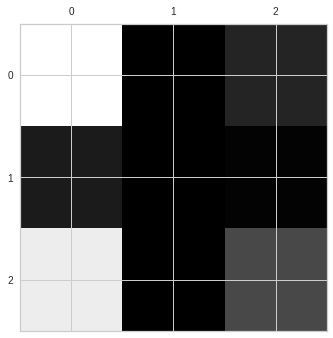

In [56]:
forest_pred = forest_clf.predict(X_valid) # X_valid로 예측 label 생성
forest_prob = forest_clf.predict_proba(X_valid) # X_valid로 예측 확률값 생성
forest_conf_mx =  confusion_matrix(y_valid, forest_pred)
print( "RandomForestClassifier confusion_matrix\n", forest_conf_mx )
print( "accuracy=", accuracy_score(y_valid, forest_pred) )# 정확도
print('Precision:',precision_score(y_valid, forest_pred, average = 'macro'))
print('Recall:',recall_score(y_valid, forest_pred, average = 'macro'))
print('F1 score:',f1_score(y_valid, forest_pred, average = 'macro'))
print('AUC:',roc_auc_score(y_valid, forest_prob, multi_class = 'ovr'))
print(classification_report(y_valid, forest_pred)) # 각 scores를 보기좋게 table 방식 표시

plt.matshow(forest_conf_mx, cmap=plt.cm.gray) # matplot의 matshow()함수를 이용해서 시각적으로 확인
plt.show()

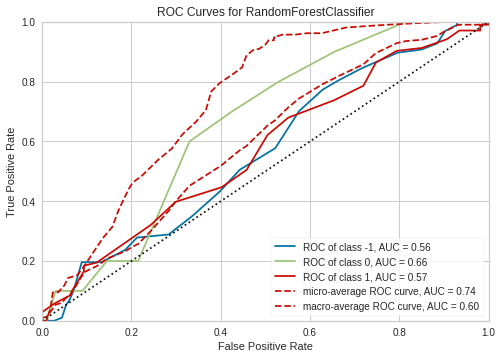

AUC= 0.5985684305423581


In [35]:
# ROC 커브 그리기
plt_roc_curve = ROCAUC(forest_clf) #

# Fitting to the training data first then scoring with the test data                                    
plt_roc_curve.fit(X_train, y_train)
plt_roc_curve.score(X_valid, y_valid)
plt_roc_curve.show()

print("AUC=", plt_roc_curve.score_)

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51333 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47785 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 44277 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 47588 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 51092 missing from current font.
  font.set_

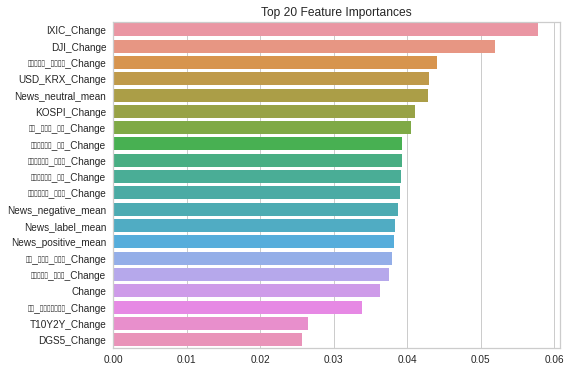

In [71]:
# Random Forest의 각 피처의 중요도 시각화 : feature_importances_
X_train_colums = [c for c in samsung_stock_ex.columns if c not in ['NextDay_Change','NextDay_Class']]

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

ftr_importances_values = forest_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values, index = X_train_colums)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Top 20 Feature Importances')
sns.barplot(x=ftr_top20, y=ftr_top20.index)
plt.show()

#### 모델 선택 및 튜닝

In [ ]:
# 모델 선택 및 튜닝 : GridSearchCV - RandomForestClassifier

In [49]:
#GridSearchCV 활용하여 RandomForestClassifier 모델의 하이퍼파라미터 조합을 탐색
#param_grid = {
#        'n_estimators': # 결정 트리의 수 (기본 10), 클수록 좋은 성능이 나올 수 있으나, 무조건은 아님
#        'max_depth':  # 최대 깊이
#        'max_features' : 'auto' -- 최적의 분할을 위해 고려할 최대 feature 개수, Default = 'auto' (결정트리에서는 default가 none이었음)
#        'min_samples_leaf': # 리프 노드가 되기 위한 최소한의 샘플 수
#        'min_samples_split': # 노드를 분할하기 위한 최소 데이터 수
#        'bootstrap': [False, True] # tree가 조금씩 다른 데이터셋으로 만들지
#}
param_grid = [
        {'n_estimators': [3, 10, 50, 100, 200], 'max_features': [5,10,30,40,50]}  # n_estimators : (기본 10), 클수록 좋은 성능이 나올 수 있으나, 무조건은 아님, max_features : 최대 선택할 특성의 수량
        #{'n_estimators': [3, 10, 50, 100, 200]}
        ,{'bootstrap': [False], 'n_estimators': [3, 10, 50], 'max_features': [5,10,30,40,50]}, # bootstrap : tree가 조금씩 다른 데이터셋으로 만들지
        #,{'bootstrap': [False], 'n_estimators': [3, 10, 50]}
    ]
#scorers = {
#    'precision_score': make_scorer(precision_score),
#    'recall_score': make_scorer(recall_score),
#    'accuracy_score': make_scorer(accuracy_score),
#    'roc_auc_score': make_scorer(roc_auc_score)
#    'roc_auc_ovr': make_scorer(roc_auc_score, needs_proba=True, multi_class=ovr) -- (OneVsRest)
#    'roc_auc_ovo': make_scorer(roc_auc_score, needs_proba=True, multi_class=ovo)...등
#}
g_forest_clf = RandomForestClassifier()
grid_search = GridSearchCV(g_forest_clf, param_grid, cv=3, 
                           scoring="roc_auc_ovr", # True Positive 를 중요하게 생각하여 scoring는 roc_auc_ovr 사용, AUC가 높으면 분류 모델 성능이 좋다고 할 수 있음
                           return_train_score=True)
 
grid_search.fit(X_train, y_train) # 모델 피팅 : train_data, train_label

grid_search.best_params_ # 주어진 조건중에 최적의 파라미터 표시

/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
24 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
15 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 467, in fit
    for i, t in enumerate(trees)
  File "/usr/local/lib/python3.7/dist-packages/joblib/parallel.py", line 1043, in __call__
    if self.dispatch_one_batch(iterator):
  File "/usr/local/lib/python3.7/dist-packages/joblib/par

{'max_features': 5, 'n_estimators': 100}

In [50]:
# grid_search 평가 점수 목록
cvres = grid_search.cv_results_
#print(cvres)
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
  print(mean_score, params)

#scores_df = pd.DataFrame(grid_search.cv_results_)
#scores_df = scores_df[["params", "mean_test_score", "rank_test_score", "split0_test_score", "split1_test_score", "split2_test_score"]]
#print(scores_df)

# 최고의 파라미터 저장해줌
print(f"최적의 파라미터: {grid_search.best_params_}")
print(f"최고 roc_auc_ovr 점수: {grid_search.best_score_}")

0.5267238849701351 {'max_features': 5, 'n_estimators': 3}
0.5387111269647614 {'max_features': 5, 'n_estimators': 10}
0.553387838690334 {'max_features': 5, 'n_estimators': 50}
0.603430089573978 {'max_features': 5, 'n_estimators': 100}
0.600364653607765 {'max_features': 5, 'n_estimators': 200}
0.5364142268433074 {'max_features': 10, 'n_estimators': 3}
0.5275054901528143 {'max_features': 10, 'n_estimators': 10}
0.5781672243864174 {'max_features': 10, 'n_estimators': 50}
0.570682809756097 {'max_features': 10, 'n_estimators': 100}
0.5972839859944171 {'max_features': 10, 'n_estimators': 200}
0.5313410204682794 {'max_features': 30, 'n_estimators': 3}
0.555863562980453 {'max_features': 30, 'n_estimators': 10}
0.573151058158259 {'max_features': 30, 'n_estimators': 50}
0.5793307027535693 {'max_features': 30, 'n_estimators': 100}
0.5731311062575543 {'max_features': 30, 'n_estimators': 200}
0.546012095274575 {'max_features': 40, 'n_estimators': 3}
0.5404828848283714 {'max_features': 40, 'n_estimat